In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('datasets/cardataset.csv') # year highway-mpg city-mpg price horsepower !
df.rename(columns={"Year":"year","highway MPG":"highway-mpg","city mpg":"city-mpg","MSRP":"price","Engine HP":"horsepower"}, inplace=True)

In [17]:
# df.info()

In [18]:
# df.describe()

# Exploring the data!

In [19]:
# df.hist(bins=50, figsize=(20,15))
# bins are the number of bars you will use to show the data
# figsize defines how big each box will be for graph
# save_fig("attribute_history_gram") this is used to save the figure (I'm still not sure if I'm going to use it)
# df.show()

# df.info()

# price highway-mpg city-mpg horsepower
# price 5118 to 45400
# hwmpg 16 to 54
# citympg 13 to 49
# hp 48 to 288
print(df[['price','highway-mpg','city-mpg','horsepower']].describe())
# print(df_num['highway-mpg'].describe())
# print(df_num['city-mpg'].describe())
# print(df_num['horsepower'].describe())

              price   highway-mpg      city-mpg   horsepower
count  1.191400e+04  11914.000000  11914.000000  11845.00000
mean   4.059474e+04     26.637485     19.733255    249.38607
std    6.010910e+04      8.863001      8.987798    109.19187
min    2.000000e+03     12.000000      7.000000     55.00000
25%    2.100000e+04     22.000000     16.000000    170.00000
50%    2.999500e+04     26.000000     18.000000    227.00000
75%    4.223125e+04     30.000000     22.000000    300.00000
max    2.065902e+06    354.000000    137.000000   1001.00000


In [20]:
corr_matrix = df.corr() 
corr_matrix
# looking at how the other numberic features relate to median_house_value
corr_matrix['price'].sort_values(ascending=False)

price               1.000000
horsepower          0.662008
Engine Cylinders    0.531312
year                0.227590
Popularity         -0.048476
Number of Doors    -0.126635
city-mpg           -0.157676
highway-mpg        -0.160043
Name: price, dtype: float64

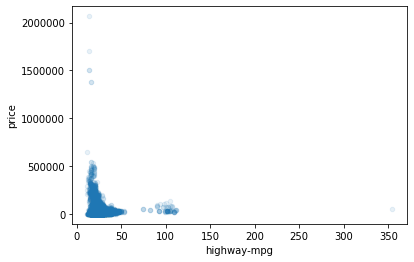

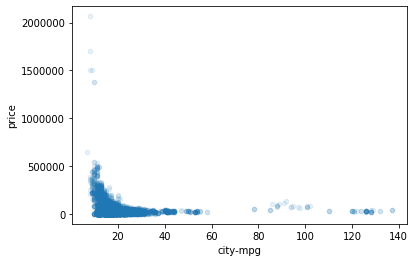

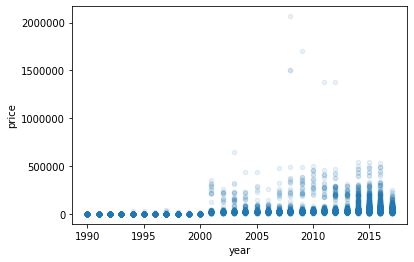

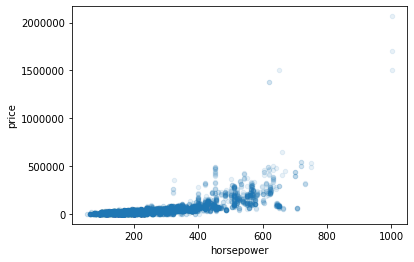

In [21]:
# df.plot(kind="scatter", x='engine-size', y='price', alpha=0.1) I'm letting this go because getting engine-size seems impossible in production
df.plot(kind="scatter", x='highway-mpg', y='price', alpha=0.1)
df.plot(kind="scatter", x='city-mpg', y='price', alpha=0.1)
df.plot(kind="scatter", x='year', y='price', alpha=0.1)
df.plot(kind="scatter", x='horsepower', y='price', alpha=0.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fa2f610>,
      dtype=object)

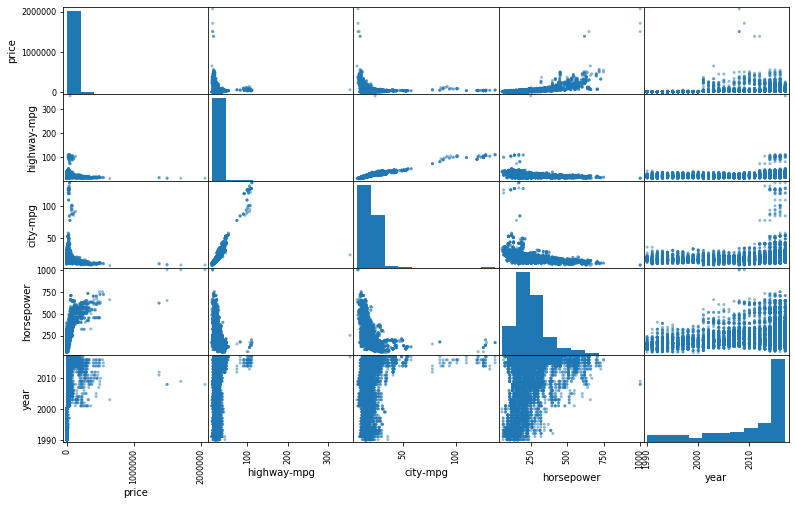

In [22]:
from pandas.plotting import scatter_matrix
attr = ['price','highway-mpg','city-mpg','horsepower','year']
scatter_matrix(df[attr], figsize=(13,8))


# Cleaning the data!

## Cleaning the numeric data!

In [23]:
df = df.replace('?', np.nan)


In [24]:
# NOT SURE IF THIS IS NEEDED BC THE FEATURES AND LABEL SHOULD ALREADY BE NUMERIC
df['price'] = pd.to_numeric(df['price'])
df['horsepower'] = pd.to_numeric(df['horsepower'])


In [25]:
from sklearn.impute import SimpleImputer
# making the imputer and telling it to replace missing values with the median
imputer = SimpleImputer( strategy='median') # missing_values = np.nan,
# selecting the numeric columns so we don't break the imputer
df_num = df.select_dtypes(include=[np.number])
# print(df_num.shape)
print(len(df_num.columns))
print(df_num.columns)
# median is in statistics_ variable
imputer.fit(df_num)
x = imputer.transform(df_num)
len(x[0])
# creating a dataframe without any missing numeric types
df_num = pd.DataFrame(x, columns = df_num.columns, index=df_num.index)


8
Index(['year', 'horsepower', 'Engine Cylinders', 'Number of Doors',
       'highway-mpg', 'city-mpg', 'Popularity', 'price'],
      dtype='object')


### Scaling
* standardization
    * benefit: less effected by outliers
    * todo: y = (number - mean) / standard diviation
    * toundo: number = y * standard diviation + mean
    * is not bound between 0 - 1
    * Scikit does this with StandardScaler

In [26]:
# std_obj will be --> { 'col_name' : {'mean': #, 'std': #} }
std_obj = {} 
def std(df, cols = []):
#     y = (number - mean) / standard diviation
#     get means
#     get stds
#     loop thru cols
#     loop thru rows and standardize (in array)
#     return (df, std_obj)
    std_obj = {}
    means = {}
    stds = {}
    for col in cols:
        std_obj[col] = {}
        std_obj[col]["mean"] =  df[col].mean()
        std_obj[col]["std"] =  df[col].std()

    for col in cols:
        data = np.array([])
        for i in df.index:
            data = np.append(data, (df[col][i] - std_obj[col]["mean"]) / std_obj[col]["std"] )
        df[col] = data 
    return (df, std_obj)

def undo_std(df, cols = [], std_obj = {}):
#   number = y * standard diviation + mean
#     loop thru cols
#     loop thru rows and un-standardize (in array)
#     return df
    for col in cols:
        data = np.array([])
        for i in df.index:
            data = np.append(data, (df[col][i] * std_obj[col]["std"]) + std_obj[col]["mean"] )
        df[col] = data
    return df


In [27]:
# std_obj def std(df, cols = []): return (df, std_obj) def undo_std(df, cols = [], std_obj = {}): return df 
print( df_num['price'].mean() )
df_num, std_obj = std(df_num, cols = ['horsepower','price','highway-mpg','city-mpg','year'])
print( df_num['price'].mean() )


40594.737032063116
5.231182841835341e-16


## Cleaning categorical data!

In [28]:
df_cat = df.select_dtypes(exclude=[np.number])

In [29]:
df_cat = df_cat.fillna("other")

In [30]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
df_cat_encoder = ordinal_encoder.fit_transform(df_cat)
# ordinal_encoder.categories_


## Combining the cleaned num and cat dataframes

In [31]:
# df = df_num.append(df_cat, ignore_index = False, sort=True) THIS CRAP DOESN'T WORK AT ALL (it adds more rows not columns)
for col in df_num:
    df[col] = df_num[col]
for col in df_cat:
    df[col] = df_cat[col]


# Split data into training and test data

In [47]:
from sklearn.model_selection import train_test_split # 'highway-mpg','city-mpg','horsepower','price','year'

train_set, test_set = train_test_split(df[['highway-mpg','city-mpg','horsepower','price','year']], test_size=0.2, random_state=42)

In [48]:
# train_set.describe()

,highway-mpg,city-mpg,horsepower,price,year
count,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000
mean,-0.000200,-0.004549,-0.002094,0.003495,0.003957
std,0.986937,0.945081,1.001907,1.041648,0.995230
min,-1.651527,-1.305465,-1.783995,-0.642078,-2.689319
25%,-0.523241,-0.415369,-0.727868,-0.325030,-0.446498
50%,-0.071927,-0.192845,-0.204397,-0.176425,0.608947
75%,0.379388,0.252202,0.466014,0.030740,0.740878
max,36.935855,13.047327,6.903796,33.693852,0.872809


In [50]:
# test_set.describe()

# Build pipeline

In [51]:
# TODO: build pipeline to automate the cleaning of datav (remember 'full_pipline')

# Select a model

## Linear Regression

In [52]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
x = train_set[['highway-mpg','city-mpg','horsepower','year']]
y = train_set['price']
lin_reg.fit(x,y) ## 'highway-mpg','city-mpg','horsepower','price','year'
# print( lin_reg.score(x,y) )
# print( lin_reg.coef_ )


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Decision Tree Regressor

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

## Random Forest Regression

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(x,y)

/Users/sheldonmaygunlogson/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# Testing the models

## RMSE

In [55]:
# rmse
from sklearn.metrics import mean_squared_error

def rmse(model, data_prepared, labels):
    predictions = model.predict(data_prepared)
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    return rmse

lin_rmse = rmse(lin_reg, x, y) 
print('Linear Regression RMSE:', lin_rmse)
tree_rmse = rmse(tree_reg, x, y)
print('Decision Tree Regression RMSE:', tree_rmse)
forest_rmse = rmse(forest_reg, x, y)
print('Random Forest Regression RMSE:', forest_rmse)


Linear Regression RMSE: 0.7858639985816503
Decision Tree Regression RMSE: 0.20271181752448134
Random Forest Regression RMSE: 0.23782614741532118


## Cross Validation

In [56]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print('Scores:', scores, 'Score len:', len(scores))
    print('Mean:', scores.mean()) 
    print('Standard Deviation:', scores.std())

In [57]:
# # lin_reg tree_reg forest_reg
print('lin_rmse')
scores = cross_val_score(lin_reg, x, y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)
print('tree_rmse')
scores = cross_val_score(tree_reg, x, y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)
print('forest_rmse')
scores = cross_val_score(forest_reg, x, y, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

lin_rmse
Scores: [1.0892485  0.63747938 0.52436377 0.55708133 0.55556819 1.12409946
 1.06819858 0.49523852 0.58705198 0.87490237] Score len: 10
Mean: 0.7513232085687974
Standard Deviation: 0.24534114800111942
tree_rmse
Scores: [0.53690587 0.73465715 0.18517349 0.29965114 0.16492792 0.82721638
 0.3579542  0.22314917 0.1416008  0.45444738] Score len: 10
Mean: 0.39256834775519933
Standard Deviation: 0.22955567947263453
forest_rmse
Scores: [0.53003116 0.54740946 0.37415966 0.257386   0.18815404 0.78736633
 0.32881979 0.20061478 0.17511056 0.3085114 ] Score len: 10
Mean: 0.36975631767908096
Standard Deviation: 0.18686766125892584


In [58]:
# put results from testing models on test dataset here

# Saving Models in Pickles!

In [59]:
import joblib # lin_reg tree_reg forest_reg
joblib.dump(lin_reg, 'models/df_1_lin_reg.pkl')
joblib.dump(tree_reg, 'models/df_1_tree_reg.pkl')
joblib.dump(forest_reg, 'models/df_1_forest_reg.pkl')

['models/df_1_forest_reg.pkl']

## How to load the models

In [61]:
lr = joblib.load('models/df_1_lin_reg.pkl')
tr = joblib.load('models/df_1_tree_reg.pkl')
fr = joblib.load('models/df_1_forest_reg.pkl')

x_test = test_set[['highway-mpg','city-mpg','horsepower','year']]
y_test = test_set['price']

lr_rmse = rmse(lr, x_test, y_test) 
print('Linear Regression RMSE:', lr_rmse)
# print( df['price'].describe() ) 
# tree_rmse = rmse(tree_reg, x, y)
# print('Decision Tree Regression RMSE:', tree_rmse)
# forest_rmse = rmse(forest_reg, x, y)
# print('Random Forest Regression RMSE:', forest_rmse)

Linear Regression RMSE: 0.5462678861051063


# Trying to fix the scaling prediction problem
Everything below this point is chaos that no man can handle

In [ ]:
# df[['horsepower','price','highway-mpg','city-mpg']] = scaler.fit_transform(df_num[['horsepower','price','highway-mpg','city-mpg']])
# lin_reg tree_reg forest_reg
x = test_set[['highway-mpg','city-mpg','horsepower']]
y = test_set['price']
p = forest_reg.predict(x)
# p = pd.Series(p, name="price").to_frame()
data = np.array([])
idx = 0 # this is the only way to iterate through p
for i in y.index:
    data = np.append( data, abs( y[i] - p[idx] ) )
    _y = int( y[i] * std_obj['price']['std'] + std_obj['price']['mean'] )
    _p = int( p[idx] * std_obj['price']['std'] + std_obj['price']['mean'] )
    print(_y,'\t', _p )
    idx += 1

mean_diff_df = pd.DataFrame()
mean_diff_df['price'] = data
print(mean_diff_df['price'].mean())
mean_diff_df = undo_std(mean_diff_df, ['price'], std_obj)
print(mean_diff_df['price'].mean())
# print(mean_diff_df)
# for i in mean_diff_df.index:
#     print(mean)

In [ ]:
# std_obj def std(df, cols = []): return (df, std_obj) def undo_std(df, cols = [], std_obj = {}): return df 
# df_num[['horsepower','price','highway-mpg','city-mpg']]
temp_df = test_set[['highway-mpg','city-mpg','horsepower','price']]
x = temp_df[['highway-mpg','city-mpg','horsepower']] # .iloc[:3]
p = lin_reg.predict(x)
p = pd.Series(p, name="price").to_frame() # this turns the np array coming from predict into series then df
y = test_set[['price']] # .iloc[:3]
# print( type(test_set[['highway-mpg','city-mpg','horsepower','price']]) )
# print( type(x) )
# print( test_set.shape )
# print( temp_df.shape ) 
# print( x.shape )
# print( p.shape )
# print( y.shape )
# print(type(p))
data = np.array([])
# print(y)
# print(p.index)
idx = 0 # this is the only way to iterate through p
for i in y.index:
    temp = y['price'][i]
    data = np.append( data, abs( y['price'][i] - p['price'][idx] ) )
#     print(temp , p['price'][idx])
#     print(i)
    idx += 1

temp_df['price'] = data
# df_num[['horsepower','price','highway-mpg','city-mpg']] 
# = scaler.fit_transform(df_num[['horsepower','price','highway-mpg','city-mpg']])
print(p.iloc[:4])
print(temp_df.iloc[:4])
temp_df[['horsepower','price','highway-mpg','city-mpg']] = undo_std(temp_df, ['horsepower','price','highway-mpg','city-mpg'], std_obj)# scaler.inverse_transform(temp_df)
test_set[['horsepower','price','highway-mpg','city-mpg']]  = undo_std(test_set, ['horsepower','price','highway-mpg','city-mpg'], std_obj)# scaler.inverse_transform(test_set)
# df['horsepower','price','highway-mpg','city-mpg'] = scaler.inverse_transform(df['horsepower','price','highway-mpg','city-mpg'])
# print(p['price'].mean())
# print(data.mean())
# print(temp_df['price'].mean())
# print(test_set['price'].mean())

# print(data[:4])
print(temp_df.iloc[:4])
print(test_set.iloc[:4])
df = pd.read_csv('datasets/cars_data.csv')
print(df[['horsepower','price','highway-mpg','city-mpg']].iloc[15])
# print(p.iloc[:4])
# print(p['price'].mean())
# print(y['price'].mean())
# print(temp_df)

In [ ]:
import joblib
# to save
joblib.dump(my_model, 'my_model.pkl')
# to read from pickel ( .pkl ) file
my_model_loaded = joblib.load('my_model.pkl')